# Battery Discharge Curve

Testing the AutoAuto 2-cell LiPo battery, specifically plotting the battery's dicharge curve with the goal of characterizing it so we can predict battery `minutes remaining` and `percentage remaining` while the car is running.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

### Load the Data

This data was collected by doing a constant-power drain on the battery. The method was **not** perfect, but it was certainly "good enough" for our needs.

We achieved this _roughly_ constant-power drain from the battery by drawing a constant current through the on-board 5v switching DC-DC step-down regulator. We assume that the converter's efficiency is constant over the entire voltage range of the battery (~8.2v down to ~6.5v). With that assumption, and by drawing constant current from the output of the switching regulator, we can conclude that the battery saw a (roughly) constant-power drain.

But how much current did we draw from the output of the 5v regulator? The 5v regulator was powering the following fixed-current devices:
1. A constant-current device set to draw 1A.
2. The onboard microcontroller.
3. The onboard IMU.

The microcontroller and IMU should draw a constant current when idle (approx. 67 mA by my measurements).

We also had the ESC plugged in during this test. The ESC draws ~100 mA when it's idle, for some dumb reason, and it doesn't go through the 5v regulator. This breaks our "constant power" assumption but we'll move ahead anyway.

All told let's ballpark say we're drawing the following constant power from the battery:
- 1A * 5v * 90% efficiency
- 67 mA * 5v * 90% efficiency
- 100 mA * 7.5v

Equals: 5.55 W

The battery we're using is rated for 2200 mAh, so if we squint and consider an ideal battery at its nominal voltage, let's say that's approximately 2.2 A * 7.5v for one hour which is 16.5 Wh. That means, by these very very rough calculations, that our battery in this configuration should last ~3 hours. The actuall test which follows shows it lasted 2 hours and 18 minutes. Eh, whatever. We just care about the discharge curve, so this data is useful for that reason.

In [2]:
df = pd.read_csv("batlog_1A.csv")

df.rename(columns={'index': 'counter'}, inplace=True)

df.index = pd.to_timedelta(df.time, unit='second')

df.head()

,counter,time,millivolts
time,,,
00:00:00.010848,0,0.010849,8230
00:00:01.013289,1,1.013290,8230
00:00:02.009260,2,2.009261,8230
00:00:03.011258,3,3.011258,8230
00:00:04.011894,4,4.011894,8230


### Check the Collection Rate

My data collecting script should have recorded one observation per second. I want to sanity check it by comparing the counter with the timestamp to be sure my program "kept up" with the logging as it should have.

In [3]:
diffs = df.time - df.counter

print(diffs.min(), diffs.max())

assert 0 <= diffs.min() <= 0.3
assert 0 <= diffs.max() <= 0.3

0.007676362991333008 0.12233114242508236


### Visualize

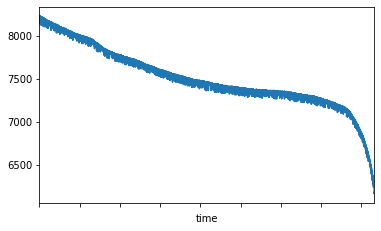

In [4]:
df.millivolts.plot()

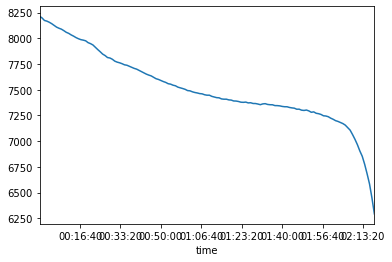

In [5]:
df.millivolts.resample('1min').mean().plot()

### Build a Lookup Table

The curve doesn't follow any common function. It is its own thing. We'll build a lookup table so we can estimate the `percentage remaining` at any given voltage.

We'll don't want to let the the voltage drop _way off_ as you see in the plot above. That's a bit too risky and hard on the battery. We'll declare that 7100 millivolts is 0% battery.

We'll also declare that 8150 is fully charged even though you see above that the battery starts a bit above that. My reasoning is that I want the user to see "100%" for a few minutes when they first turn on the car. It's what they'll expect.

Finally, we'll use the average values over each minutes because the per-second data is way too noisy and it would be rediculous to use the per-second data anyway because no one thinks of battery lifetime in seconds.

In [6]:
min_millivolts = 7100   # "0% battery"
max_millivolts = 8150   # "100% battery"

df_mins = df.millivolts.resample('1min').mean()

df_mins.head()

time
00:00:00.010848    8214.500000
00:01:00.010848    8198.333333
00:02:00.010848    8173.633333
00:03:00.010848    8166.950820
00:04:00.010848    8155.966102
Freq: T, Name: millivolts, dtype: float64

In [7]:
mask = (min_millivolts <= df_mins) & (df_mins <= max_millivolts)

df_mins = df_mins[mask].copy()

df_mins.head()

time
00:05:00.010848    8142.200000
00:06:00.010848    8125.666667
00:07:00.010848    8108.800000
00:08:00.010848    8097.836066
00:09:00.010848    8088.881356
Freq: T, Name: millivolts, dtype: float64

In [8]:
percentage = 100.0 - np.linspace(0.0, 100.0, len(df_mins))

df_map = pd.DataFrame({'millivolts': df_mins, 'percentage': percentage})

df_map.head()

,millivolts,percentage
time,,
00:05:00.010848,8142.200000,100.000000
00:06:00.010848,8125.666667,99.186992
00:07:00.010848,8108.800000,98.373984
00:08:00.010848,8097.836066,97.560976
00:09:00.010848,8088.881356,96.747967


In [9]:
df_map.tail()

,millivolts,percentage
time,,
02:04:00.010848,7181.766667,3.252033
02:05:00.010848,7171.533333,2.439024
02:06:00.010848,7156.426230,1.626016
02:07:00.010848,7132.576271,0.813008
02:08:00.010848,7107.666667,0.000000


In [10]:
millivolts  = df_map.millivolts.values[::-1]  # Reverse so that the values are increasing.
percentages = df_map.percentage.values[::-1]  # Reverse to match `xs`.

print(np.interp(7700.0, millivolts, percentages))
print(np.interp(8400, millivolts, percentages))
print(np.interp(6800, millivolts, percentages))

71.50809861370959
100.0
0.0


### Done!

We've created a map between battery millivolts and `percentage remaining`!

Let's store the results.

In [11]:
np.savez_compressed("battery_percentage_map.npz", millivolts=millivolts, percentages=percentages)